## 1. Model Defnition

In [1]:
import torch
import torch.nn as nn
from utils_ismir import MusdbLoaer
from intermediate_layers import TFC_TDF
from frameworks import U_Net_Framework

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
musdb_loader = MusdbLoaer(n_fft=4096, hop_factor=2, dim_t=128, device=device)

def mk_tfc_tdf (input_c, output_c, f, i):
    print('intermediate\t at level', i, 'with TFC_TDF')
    return TFC_TDF(in_channels=input_c, num_layers=5, gr=output_c, kt=3, kf=3, f=f, bn_factor=16, bias=True)

t_scale = [0,1,2,3]

def mk_tfc_tdf_ds (i, f, t_scale=t_scale):
    scale = (2,2) if i in t_scale else (1,2)
    print('downsampling\t at level', i, 'with scale(T, F): ', scale, ', F_scale: ', f, '->', f//scale[-1])
    ds = nn.Sequential(
        nn.Conv2d(in_channels=24, out_channels=24, kernel_size=scale, stride=scale),
        nn.BatchNorm2d(24)
    )
    return ds, f//scale[-1]

def mk_tfc_tdf_us (i, f, n, t_scale=t_scale):
    scale = (2,2) if i in [n -1 -s for s in  t_scale] else (1,2)

    print('upsampling\t at level', i, 'with scale(T, F): ', scale, ', F_scale: ', f, '->', f*scale[-1])
    us = nn.Sequential(
        nn.ConvTranspose2d(in_channels=24, out_channels=24, kernel_size=scale, stride=scale),
        nn.BatchNorm2d(24)
    )
    return us, f*scale[-1]


model = U_Net_Framework(
    musdb_loader, est_mode='cac_mapping', internal_channels=24, num_blocks=9, 
    mk_block_f=mk_tfc_tdf, mk_ds_f=mk_tfc_tdf_ds, mk_us_f=mk_tfc_tdf_us
).to(device)

intermediate	 at level 0 with TFC_TDF
downsampling	 at level 0 with scale(T, F):  (2, 2) , F_scale:  2048 -> 1024
intermediate	 at level 1 with TFC_TDF
downsampling	 at level 1 with scale(T, F):  (2, 2) , F_scale:  1024 -> 512
intermediate	 at level 2 with TFC_TDF
downsampling	 at level 2 with scale(T, F):  (2, 2) , F_scale:  512 -> 256
intermediate	 at level 3 with TFC_TDF
downsampling	 at level 3 with scale(T, F):  (2, 2) , F_scale:  256 -> 128
intermediate	 at level 3 with TFC_TDF
upsampling	 at level 0 with scale(T, F):  (2, 2) , F_scale:  128 -> 256
intermediate	 at level 0 with TFC_TDF
upsampling	 at level 1 with scale(T, F):  (2, 2) , F_scale:  256 -> 512
intermediate	 at level 1 with TFC_TDF
upsampling	 at level 2 with scale(T, F):  (2, 2) , F_scale:  512 -> 1024
intermediate	 at level 2 with TFC_TDF
upsampling	 at level 3 with scale(T, F):  (2, 2) , F_scale:  1024 -> 2048
intermediate	 at level 3 with TFC_TDF


In [2]:
print('# params:', sum(p.numel() for p in model.parameters() if p.requires_grad) )

# params: 2232132


## 2. Load Pretrained Model

In [3]:
!ls pretrained | grep cac_tfc_tdf_large

cac_tfc_tdf_large_vocals.pt


In [4]:
model = nn.DataParallel(model, device_ids=[0,1,2,3]).to(device)
pretrained_params = torch.load('pretrained/cac_tfc_tdf_large_vocals.pt', map_location=device)
model.load_state_dict(pretrained_params)

<All keys matched successfully>

## 3. Evaluation: Musdb18 Benchmark

### 3.1 SDR performance of the pretrained U-Net with 17 TFC_TDF blocks

8.19998045664882


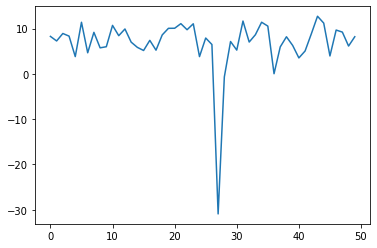

SDR mean: 6.822240998631778
SDR median: 8.05138464498863
SDR medians:  8.05138464498863


In [6]:
from utils_ismir import separate, eval_testset
import statistics as stats

def separator (mix):
    return separate(musdb_loader, model, mix, batch_size=16)

sdrs, sdr_mean, sdr_median  = eval_testset(musdb_loader, separator, target_name='vocals')
    
print('SDR medians: ', sdr_median)